绘制mask权重与是否使用的热力图

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(data, idx=0, shape=(32, 32)):
    n_layers, n_heads = shape
    data = data.flatten()
    heatmap = np.zeros((n_layers, n_heads))
    for i in range(n_layers):
        heatmap[i, :] = data[i*n_layers:i*n_layers+n_heads]

    # 创建包含两个子图的figure, 左右显示
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]})

    # 绘制左侧的热力图
    cax1 = ax1.imshow(heatmap[::-1, :], cmap='viridis', aspect='auto', vmin=0., vmax=1.)
    fig.colorbar(cax1, ax=ax1, fraction=0.046, pad=0.08)

    # 设置左侧热力图的刻度标签
    ax1.set_yticks([])
    ax1.set_xticks(np.arange(0, n_heads, 4))

    ax_left1 = ax1.twinx()
    ax_left1.yaxis.tick_left()
    ax_left1.set_ylim(0, n_layers * 2)
    ax_left1.set_yticks(np.arange(0, n_layers * 2, 2) + 0.5)
    ax_left1.set_yticklabels(np.arange(n_layers), fontsize=10)
    ax_left1.set_ylabel("Attention Layer")
    ax_left1.yaxis.set_label_position("left")

    ax_right1 = ax1.twinx()
    ax_right1.yaxis.tick_right()
    ax_right1.set_ylim(0, n_layers * 2)
    ax_right1.set_yticks(np.arange(1, n_layers * 2, 2) + 0.5)
    ax_right1.set_yticklabels(np.arange(n_layers), fontsize=10)
    ax_right1.set_ylabel("FFN Layer")
    ax_right1.yaxis.set_label_position("right")

    # 绘制右侧的热力图
    cax2 = ax2.imshow((heatmap[::-1, :] >= 0.5), cmap='viridis', aspect='auto', vmin=0., vmax=1.)
    fig.colorbar(cax2, ax=ax2, fraction=0.046, pad=0.08)

    # 设置右侧热力图的刻度标签
    ax2.set_yticks([])
    ax2.set_xticks(np.arange(0, n_heads, 4))

    ax_left2 = ax2.twinx()
    ax_left2.yaxis.tick_left()
    ax_left2.set_ylim(0, n_layers * 2)
    ax_left2.set_yticks(np.arange(0, n_layers * 2, 2) + 0.5)
    ax_left2.set_yticklabels(np.arange(n_layers), fontsize=10)
    ax_left2.set_ylabel("Attention Layer")
    ax_left2.yaxis.set_label_position("left")

    ax_right2 = ax2.twinx()
    ax_right2.yaxis.tick_right()
    ax_right2.set_ylim(0, n_layers * 2)
    ax_right2.set_yticks(np.arange(1, n_layers * 2, 2) + 0.5)
    ax_right2.set_yticklabels(np.arange(n_layers), fontsize=10)
    ax_right2.set_ylabel("FFN Layer")
    ax_right2.yaxis.set_label_position("right")

    # 显示最终图像
    plt.title(f"Heatmap (Training percentage {idx:03d})")
    plt.tight_layout()
    plt.show()
    plt.close()


KeyboardInterrupt: 

读取mask权重文件

In [2]:
import os
import safetensors.torch
import numpy as np

weight_dict = {}
for root, dir, files in os.walk("./output/xnli"):
    for file in files:
        if file.endswith(".safetensors") and "-6190" in root:
            langs = os.path.basename(os.path.dirname(root))
            path = os.path.join(root, file)
            weight_dict[langs] = safetensors.torch.load_file(path)["tensor"]
for root, dir, files in os.walk("./output/fv"):
    for file in files:
        if file.endswith(".safetensors") and "-6250" in root:
            langs = os.path.basename(os.path.dirname(root))
            path = os.path.join(root, file)
            weight_dict[langs] = safetensors.torch.load_file(path)["tensor"]
print(len(weight_dict))
for k, v in sorted(weight_dict.items()):
    print(k, v, (v.sigmoid() >= 0.5).sum().item())

0


统计重叠程度

共有0.0个注意力头在所有情况下都使用，1.0个注意力头在所有情况下都不使用


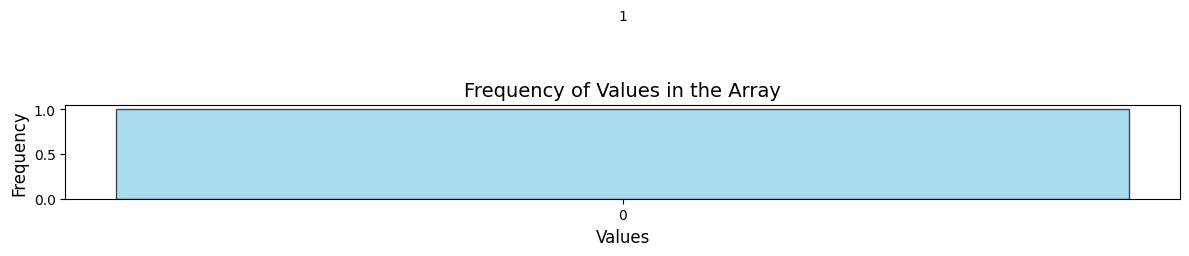

In [3]:
import numpy as np
lang_dict = {}
for root, dir, files in os.walk("./output/xnli"):
    for file in files:
        if file.endswith(".safetensors") and "-6190" in root:
            langs = os.path.basename(os.path.dirname(root))
            path = os.path.join(root, file)
            lang_dict[langs] = safetensors.torch.load_file(path)["tensor"]
task_dict = {}
for root, dir, files in os.walk("./output/fv"):
    for file in files:
        if file.endswith(".safetensors") and "-6250" in root:
            langs = os.path.basename(os.path.dirname(root))
            path = os.path.join(root, file)
            task_dict[langs] = safetensors.torch.load_file(path)["tensor"]

all_weights = np.array([(lang_dict[pair].sigmoid() >= 0.5).float().numpy() for pair in lang_dict.keys()])
all_common_weight = ((all_weights.sum(axis=0) == 42)).astype(float)
all_empty_weight = ((all_weights.sum(axis=0) == 0)).astype(float)
print(f"共有{all_common_weight.sum()}个注意力头在所有情况下都使用，{all_empty_weight.sum()}个注意力头在所有情况下都不使用")

all_lang_weights = np.array([(lang_dict[lang_pair].sigmoid() >= 0.5).float().numpy() for lang_pair in lang_dict.keys()])
lang_common_weight = ((all_lang_weights.sum(axis=0) == 42)).astype(float)
for task in task_dict:
    task_weight = (task_dict[task].sigmoid() >= 0.5).float().numpy()
    intersect = np.logical_and(lang_common_weight, task_weight)
    print(f"在{task}中有{intersect.sum()/lang_common_weight.sum():.2%}的翻译用注意力头")

import matplotlib.pyplot as plt
values, counts = np.unique(all_weights.sum(axis=0), return_counts=True)
plt.figure(figsize=(12, 6))
plt.bar(values, counts, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel("Values", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Frequency of Values in the Array", fontsize=14)
plt.xticks(values)
for value, count in zip(values, counts):
    plt.text(value, count + 1, str(count), ha='center', fontsize=10)
plt.tight_layout()
plt.show()

两组mask的Jaccord相似度

In [4]:
import os
os.chdir(".")
import safetensors.torch
import pandas as pd
from IPython.display import display

weight_dict_A = {}
for root, dir, files in os.walk("./output/qwen2/xnli"):
    for file in files:
        if file.endswith(".safetensors") and "-6190" in root:
            langs = os.path.basename(os.path.dirname(root))
            path = os.path.join(root, file)
            weight_dict_A[langs] = safetensors.torch.load_file(path)["tensor"]
for root, dir, files in os.walk("./output/qwen2/fv"):
    for file in files:
        if file.endswith(".safetensors") and "-6250" in root:
            langs = os.path.basename(os.path.dirname(root))
            path = os.path.join(root, file)
            weight_dict_A[langs] = safetensors.torch.load_file(path)["tensor"]

weight_dict_B = {}
for root, dir, files in os.walk("./output/qwen2-plm/xnli"):
    for file in files:
        if file.endswith(".safetensors") and "-6190" in root:
            langs = os.path.basename(os.path.dirname(root))
            path = os.path.join(root, file)
            weight_dict_B[langs] = safetensors.torch.load_file(path)["tensor"]
for root, dir, files in os.walk("./output/qwen2-plm/fv"):
    for file in files:
        if file.endswith(".safetensors") and "-6250" in root:
            langs = os.path.basename(os.path.dirname(root))
            path = os.path.join(root, file)
            weight_dict_B[langs] = safetensors.torch.load_file(path)["tensor"]
assert len(weight_dict_A) == len(weight_dict_B)

tasks, a_num, b_num, score = [], [], [], []
random_exp = []
recalls = []
for task in weight_dict_A:
    weight_A, weight_B = weight_dict_A[task], weight_dict_B[task]
    mask_A = (weight_A.sigmoid() >= 0.5).numpy().reshape(28, 29)[:, :-1].flatten()
    mask_B = (weight_B.sigmoid() >= 0.5).numpy().reshape(28, 29)[:, :-1].flatten()
    jaccord = (mask_A & mask_B).sum() / (mask_A | mask_B).sum()
    random_jaccord = 1 / (784 * (mask_A.sum() + mask_B.sum()) / (mask_A.sum() * mask_B.sum()) - 1)
    recall = (mask_A & mask_B).sum() / mask_B.sum()
    tasks.append(task)
    a_num.append(mask_A.sum())
    b_num.append(mask_B.sum())
    score.append(jaccord)
    random_exp.append(random_jaccord)
    recalls.append(recall)
df = pd.DataFrame({
    "task": tasks,
    "Asum": a_num,
    "Bsum": b_num,
    "recall": recalls,
    "Jaccord": score,
    "random": random_exp
}).sort_values(by="task").reset_index(drop=True)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
display(df)

,task,Asum,Bsum,recall,Jaccord,random


加载模型

In [5]:
from transformers import AutoTokenizer
from models.modeling_llama import LlamaForCausalLM
from models.modeling_qwen2 import Qwen2ForCausalLM
from models.modeling_mistral import MistralForCausalLM
from models.modeling_phi3 import Phi3ForCausalLM
from models.modeling_gemma2 import Gemma2ForCausalLM
import safetensors
import torch
from torch import nn
DEVICE = "cuda:0"

MODEL_DIR = "~/PretrainedModels/llama-3.1-8b-instruct-hf"
# MODEL_DIR = "~/PretrainedModels/qwen2.5-14b-instruct"
# MODEL_DIR = "~/PretrainedModels/mistral-7b-instruct-v0.3"
# MODEL_DIR = "~/PretrainedModels/phi-3.5-mini-instruct"
# MODEL_DIR = "~/PretrainedModels/gemma-2-2b-it"
model_name = os.path.basename(MODEL_DIR)
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
model = LlamaForCausalLM.from_pretrained(
    MODEL_DIR, 
    local_files_only=True, 
    device_map=DEVICE, 
    torch_dtype=torch.bfloat16,
    attn_implementation="eager",
    max_position_embeddings=2048
)
model.generation_config.pad_token_id = tokenizer.pad_token_id
n_layers = model.config.num_hidden_layers
n_heads = model.config.num_attention_heads

RuntimeError: operator torchvision::nms does not exist

使用mask做生成

In [ ]:
LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
QWEN2_TEMPLATE = "<|im_start|>user\n{src}<|im_end|>\n<|im_start|>assistant\n"
QWEN2_PLM_TEMPLATE = "{src}\n\n"
PHI3_TEMPLATE = "<|user|>\n{src}<|end|>\n<|assistant|>\n"
GEMMA2_TEMPLATE = "<bos><start_of_turn>user\n{src}<end_of_turn>\n<start_of_turn>model\n"

input_str = "I have never seen such a beautiful sunset."
src_lang = "en"
tgt_langs = ["zh", "fr", "es", "de", "ru", "ar"]

with torch.no_grad():
    lm_inputs_src = tokenizer([LLAMA_TEMPLATE.format(src=input_str)+""], add_special_tokens=False, return_tensors="pt").to(DEVICE)
    generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=None, do_sample=False)
    pred_str = tokenizer.decode(generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
    print("[ORIGINAL]", pred_str)
    for tgt_lang in tgt_langs:
        weights_tensor = (weight_dict[f"{src_lang}_{tgt_lang}"].unsqueeze(0).repeat(1, 1).to(model.device).sigmoid() >= 0.5)
        generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=weights_tensor, do_sample=False)
        pred_str = tokenizer.decode(generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
        print(f"[{tgt_lang}]", pred_str)

In [ ]:
import numpy as np
test_weight = (weight_dict["en_de"].sigmoid() >= 0.5).float().numpy().clip(min=0.0)
print(test_weight.sum())

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "<|begin_of_text|>{src}\n\n"
QWEN2_TEMPLATE = "<|im_start|>user\n{src}<|im_end|>\n<|im_start|>assistant\n"
MISTRAL_TEMPLATE = "<s>[INST] {src}[/INST]"
PHI3_TEMPLATE = "<|user|>\n{src}<|end|>\n<|assistant|>\n"
input_str = "This is expected as the model has lost the majority of its attention heads.\n\nTranslate into Chinese:"
src_lang = "en"
tgt_lang = "zh"

with torch.no_grad():
    lm_inputs_src = tokenizer([LLAMA_TEMPLATE.format(src=input_str)+""], add_special_tokens=False, return_tensors="pt").to(DEVICE)
    generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=None, do_sample=False)
    pred_str = tokenizer.decode(generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
    print("[ORIGINAL]", pred_str)

    weights_tensor = torch.tensor(test_weight).unsqueeze(0).repeat(1, 1).to(model.device)
    random_tensor = torch.tensor(test_weight)[torch.randperm(len(test_weight))].unsqueeze(0).repeat(1, 1).to(model.device)
    generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=weights_tensor, do_sample=False)
    pred_str = tokenizer.decode(generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
    print(f"[{tgt_lang}]", pred_str)

层间输出相似度，以及top tokens

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
input_str = "I see a llama sleeping in my backyard."
input_str_inst = input_str + ""
src_lang = "en"
tgt_lang = "zh"

with torch.no_grad():
    lm_inputs_src_inst = tokenizer([LLAMA_TEMPLATE.format(src=input_str_inst)+""], add_special_tokens=False, return_tensors="pt").to(DEVICE)
    lm_inputs_src = tokenizer([LLAMA_TEMPLATE.format(src=input_str)+""], add_special_tokens=False, return_tensors="pt").to(DEVICE)

    original_output = model(**lm_inputs_src_inst, output_hidden_states=True, output_attentions=True)
    layer_outputs = torch.stack(original_output.hidden_states)    # (1 + n_layers, bsz, seq_len, hidden_size)
    layer_token_logits = model.lm_head(layer_outputs[:, 0, -1])
    original_layer_pred_tokens = tokenizer.batch_decode(layer_token_logits.argmax(-1))
    original_layer_pred_tokens_top5 = [tokenizer.batch_decode(layer_token_logits.argsort(dim=-1, descending=True)[:, k]) for k in range(5)]
    original_res = layer_outputs[1:, 0, -1] - layer_outputs[:-1, 0, -1]

    weights_tensor = torch.tensor((weight_dict["en_zh"].sigmoid() >= 0.5).float().numpy()).unsqueeze(0).repeat(1, 1).to(model.device)
    weighted_output = model(**lm_inputs_src, weight_tensor=weights_tensor, output_hidden_states=True, output_attentions=True)
    weighted_layer_outputs = torch.stack(weighted_output.hidden_states)
    weighted_layer_token_logits = model.lm_head(weighted_layer_outputs[:, 0, -1])
    weighted_layer_pred_tokens = tokenizer.batch_decode(weighted_layer_token_logits.argmax(-1))
    weighted_layer_pred_tokens_top5 = [tokenizer.batch_decode(weighted_layer_token_logits.argsort(dim=-1, descending=True)[:, k]) for k in range(5)]
    weighted_res = weighted_layer_outputs[1:, 0, -1] - weighted_layer_outputs[:-1, 0, -1]
    print("层hidden相似度\n", torch.cosine_similarity((layer_outputs[:, 0, -1]), (weighted_layer_outputs[:, 0, -1])))
    print("层输出logits相似度\n", torch.cosine_similarity(layer_token_logits, weighted_layer_token_logits))
    print("层残差相似度\n", torch.cosine_similarity((layer_outputs[1:, 0, -1] - layer_outputs[:-1, 0, -1]), (weighted_layer_outputs[1:, 0, -1] - weighted_layer_outputs[:-1, 0, -1])))

    pd.set_option("display.max_colwidth", None)
    pd.set_option("display.max_rows", None)
    df = pd.DataFrame({
        "original": original_layer_pred_tokens,
        "weighted": weighted_layer_pred_tokens
    })
    df1 = pd.DataFrame(original_layer_pred_tokens_top5).transpose()
    display(df1)

层hidden相似度
 tensor([1.0000, 0.8359, 0.8281, 0.8359, 0.8008, 0.8359, 0.8398, 0.8477, 0.8125,
        0.7578, 0.7344, 0.7422, 0.6680, 0.6133, 0.5312, 0.5391, 0.5469, 0.5742,
        0.5391, 0.5508, 0.5195, 0.4902, 0.4844, 0.4512, 0.4531, 0.4941, 0.5078,
        0.5156, 0.5156, 0.5312, 0.5469, 0.4824, 0.3633], device='cuda:0',
       dtype=torch.bfloat16)
层输出logits相似度
 tensor([1.0078, 0.8438, 0.8320, 0.8242, 0.8164, 0.8828, 0.9023, 0.8945, 0.8477,
        0.7891, 0.7695, 0.8125, 0.7734, 0.6484, 0.5352, 0.5547, 0.5391, 0.5938,
        0.6289, 0.6641, 0.6367, 0.6641, 0.6914, 0.5664, 0.7031, 0.8438, 0.8867,
        0.9141, 0.9180, 0.9258, 0.9180, 0.8398, 0.2090], device='cuda:0',
       dtype=torch.bfloat16)
层残差相似度
 tensor([0.7969, 0.7695, 0.7617, 0.6406, 0.7227, 0.7227, 0.6914, 0.6406, 0.5391,
        0.4980, 0.4609, 0.3594, 0.3164, 0.3086, 0.3223, 0.2930, 0.3281, 0.3418,
        0.4023, 0.3242, 0.2734, 0.3574, 0.2656, 0.2773, 0.3516, 0.3418, 0.3242,
        0.3145, 0.3770, 0.4297, 0.4355, 

,0,1,2,3,4
0,illo,abil,incer,otron,câ
1,,Alam,cheng,Voy,reff
2,'gc,,forget,.netbeans,alink
3,'gc,,purch,the,.netbeans
4,'gc,,.CR,edl,.netbeans
5,'gc,#ab,#aa,__$,-toggler
6,#ab,'gc,#aa,PFN,#ac
7,'gc,#ad,-*-\r\n,#aa,#af
8,LLU,-*-\r\n,chalk,kke,buurt
9,#ad,#ab,меть,ibase,morgan


相似度绘图

带指令全模型-去除注意力头相似度
 [1.         0.80078125 0.77734375 0.7890625  0.7421875  0.75390625
 0.73046875 0.74609375 0.69140625 0.58984375 0.55078125 0.5859375
 0.51171875 0.55859375 0.51953125 0.5625     0.60546875 0.640625
 0.68359375 0.6875     0.68359375 0.6875     0.71484375 0.734375
 0.73828125 0.734375   0.73828125 0.73046875 0.71484375 0.703125
 0.68359375 0.64453125 0.58984375]
带指令全模型-无指令全模型相似度
 [1.         0.9609375  0.90234375 0.90234375 0.84375    0.81640625
 0.76171875 0.75       0.71875    0.6328125  0.57421875 0.60546875
 0.5859375  0.69140625 0.66015625 0.62109375 0.59765625 0.53515625
 0.4765625  0.44726562 0.42773438 0.390625   0.390625   0.3671875
 0.36914062 0.40625    0.41601562 0.42578125 0.42578125 0.44726562
 0.4453125  0.39648438 0.26367188]


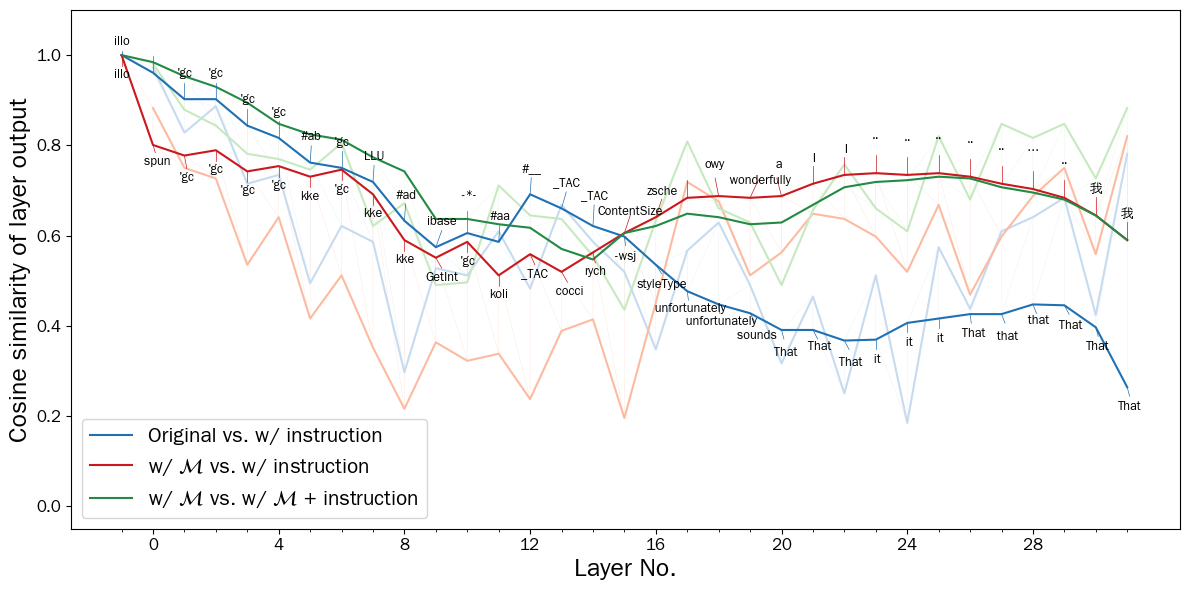

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
input_str = "I see a llama sleeping in my backyard."
input_str_inst = input_str + "\n\nTranslate into Chinese:"
target_str = "我看见一只羊驼在我的后院睡觉。"   # [-14:]

with torch.no_grad():
    lm_inputs_src_inst = tokenizer([LLAMA_TEMPLATE.format(src=input_str_inst)+target_str], add_special_tokens=False, return_tensors="pt").to(DEVICE)
    lm_inputs_src = tokenizer([LLAMA_TEMPLATE.format(src=input_str)+target_str], add_special_tokens=False, return_tensors="pt").to(DEVICE)

    original_output = model(**lm_inputs_src, output_hidden_states=True, output_attentions=True)
    layer_attn_outputs = torch.stack(original_output.attentions)    # (n_layers, bsz, seq_len, hidden_size)
    layer_outputs = torch.stack(original_output.hidden_states)    # (1 + n_layers, bsz, seq_len, hidden_size)
    layer_token_logits = model.lm_head(layer_outputs)
    layer_pred_tokens = tokenizer.batch_decode(layer_token_logits[:, 0, -15].argmax(-1))

    original_inst_output = model(**lm_inputs_src_inst, output_hidden_states=True, output_attentions=True)
    inst_layer_attn_outputs = torch.stack(original_inst_output.attentions)
    inst_layer_outputs = torch.stack(original_inst_output.hidden_states)
    inst_layer_token_logits = model.lm_head(inst_layer_outputs)
    inst_layer_pred_tokens = tokenizer.batch_decode(inst_layer_token_logits[:, 0, -15].argmax(-1))

    weights_tensor = torch.tensor((weight_dict["en_zh"].sigmoid() >= 0.5).float().numpy()).unsqueeze(0).repeat(1, 1).to(model.device)
    weighted_output = model(**lm_inputs_src, weight_tensor=weights_tensor, output_hidden_states=True, output_attentions=True)
    weighted_layer_attn_outputs = torch.stack(weighted_output.attentions)
    weighted_layer_outputs = torch.stack(weighted_output.hidden_states)
    weighted_layer_token_logits = model.lm_head(weighted_layer_outputs)
    weighted_layer_pred_tokens = tokenizer.batch_decode(weighted_layer_token_logits[:, 0, -15].argmax(-1))

    weighted_inst_output = model(**lm_inputs_src_inst, weight_tensor=weights_tensor, output_hidden_states=True, output_attentions=True)
    weighted_inst_layer_attn_outputs = torch.stack(weighted_inst_output.attentions)
    weighted_inst_layer_outputs = torch.stack(weighted_inst_output.hidden_states)
    weighted_inst_layer_token_logits = model.lm_head(weighted_inst_layer_outputs)
    weighted_inst_layer_pred_tokens = tokenizer.batch_decode(weighted_inst_layer_token_logits[:, 0, -15].argmax(-1))

    cosine_sim1 = torch.cosine_similarity((inst_layer_outputs[:, 0, -15:-14].mean(dim=-2)), (weighted_layer_outputs[:, 0, -15:-14].mean(dim=-2))).float().cpu().numpy()
    cosine_sim2 = torch.cosine_similarity((inst_layer_outputs[:, 0, -15:-14].mean(dim=-2)), (layer_outputs[:, 0, -15:-14].mean(dim=-2))).float().cpu().numpy()
    cosine_sim3 = torch.cosine_similarity((weighted_layer_outputs[:, 0, -15:-14].mean(dim=-2)), (weighted_inst_layer_outputs[:, 0, -15:-14].mean(dim=-2))).float().cpu().numpy()
    attn_cosine_sim1 = torch.cosine_similarity((inst_layer_attn_outputs[:, 0, -15:-14].mean(dim=-2)), (weighted_layer_attn_outputs[:, 0, -15:-14].mean(dim=-2))).float().cpu().numpy()
    attn_cosine_sim2 = torch.cosine_similarity((inst_layer_attn_outputs[:, 0, -15:-14].mean(dim=-2)), (layer_attn_outputs[:, 0, -15:-14].mean(dim=-2))).float().cpu().numpy()
    attn_cosine_sim3 = torch.cosine_similarity((weighted_layer_attn_outputs[:, 0, -15:-14].mean(dim=-2)), (weighted_inst_layer_attn_outputs[:, 0, -15:-14].mean(dim=-2))).float().cpu().numpy()
    print("带指令全模型-去除注意力头相似度\n", cosine_sim1)
    print("带指令全模型-无指令全模型相似度\n", cosine_sim2)
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
plt.rcParams['font.sans-serif'] = ["WenQuanYi Zen Hei"]
(b1, _, b2), (r1, _, r2), (g1, _, g2) = sns.color_palette("Blues", 3), sns.color_palette("Reds", 3), sns.color_palette("Greens", 3)
plt.figure(figsize=(12, 6))
plt.xlabel("Layer No.", fontsize=18)
plt.xticks(np.arange(1, 32, 4), labels=np.arange(0, 32, 4), fontsize=12)
plt.xticks(np.arange(33), minor=True)
plt.ylabel("Cosine similarity of layer output", fontsize=18)
plt.yticks(fontsize=12)
plt.plot(np.arange(33).repeat(2)[1:], [attn_cosine_sim2[i//2] if i % 2 else cosine_sim2[i//2] for i in range(65)], color=b1, linestyle="--", linewidth=0.2, alpha=0.8)
plt.plot(np.arange(33).repeat(2)[1:], [attn_cosine_sim1[i//2] if i % 2 else cosine_sim1[i//2] for i in range(65)], color=r1, linestyle="--", linewidth=0.2, alpha=0.8)
plt.plot(np.arange(33).repeat(2)[1:], [attn_cosine_sim3[i//2] if i % 2 else cosine_sim3[i//2] for i in range(65)], color=g1, linestyle="--", linewidth=0.2, alpha=0.8)
plt.plot(np.arange(1, 33), attn_cosine_sim2, c=b1)
plt.plot(np.arange(1, 33), attn_cosine_sim1, c=r1)
plt.plot(np.arange(1, 33), attn_cosine_sim3, c=g1)
plt.plot(cosine_sim2, label="Original vs. w/ instruction", c=b2)
plt.plot(cosine_sim1, label=r"w/ $\mathcal{M}$ vs. w/ instruction", c=r2)
plt.plot(cosine_sim3, label=r"w/ $\mathcal{M}$ vs. w/ $\mathcal{M}$ + instruction", c=g2)

texts = []
for i, (xi, yi1, yi2, yi3) in enumerate(zip(np.arange(33), cosine_sim1, cosine_sim2, cosine_sim3)):
    texts.append(
        plt.text(xi, yi1-0.05 if xi<16 else yi1+0.05, weighted_layer_pred_tokens[i], fontsize=9, ha="center")
    )
    texts.append(
        plt.text(xi, yi2+0.05 if xi<16 else yi2-0.05, layer_pred_tokens[i], fontsize=9, ha="center")
    )
    # texts.append(
    #     plt.text(xi, yi3-0.05 if xi<16 else yi3+0.05, weighted_inst_layer_pred_tokens[i], fontsize=9, ha="center")
    # )

adjust_text(texts, avoid_self=False)
for (t1, t2), xi, yi1, yi2 in zip([(texts[i], texts[i+1]) for i in range(0, len(texts), 2)], np.arange(33), cosine_sim1, cosine_sim2):
    x_text, y_text = t1.get_position()
    plt.plot([xi, x_text], [yi1, y_text+0.02 if xi<16 else yi1+0.04], color=r2, linestyle="-", linewidth=0.5)
    x_text, y_text = t2.get_position()
    plt.plot([xi, x_text], [yi2, y_text-0.02 if xi<16 else yi2-0.02], color=b2, linestyle="-", linewidth=0.5)
    # x_text, y_text = t3.get_position()
    # plt.plot([xi, x_text], [yi3, y_text+0.02 if xi<16 else yi3+0.04], color=g2, linestyle="-", linewidth=0.5)
plt.ylim(-0.05, 1.1)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig("figs/similarity.pdf", dpi=150)
plt.show()

按权重移去注意力头的过程中，层输出余弦相似度的变化

  0%|          | 0/320 [00:00<?, ?it/s]

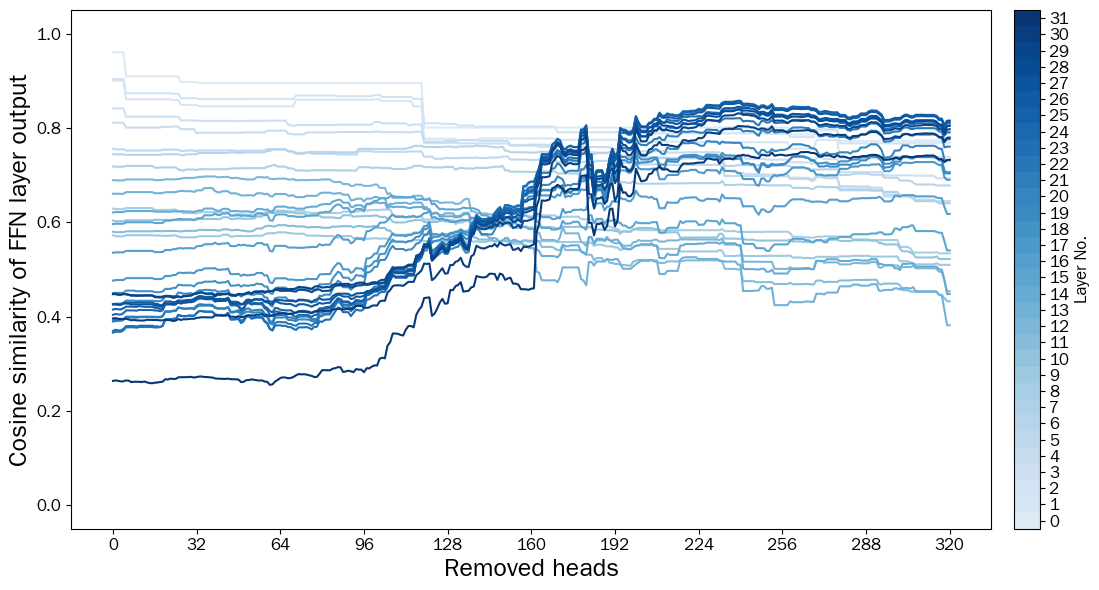

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
input_str = "I see a llama sleeping in my backyard."
input_str_inst = input_str + "\n\nTranslate into Chinese:"

with torch.no_grad():
    lm_inputs_src_inst = tokenizer([LLAMA_TEMPLATE.format(src=input_str_inst)], add_special_tokens=False, return_tensors="pt").to(DEVICE)
    lm_inputs_src = tokenizer([LLAMA_TEMPLATE.format(src=input_str)], add_special_tokens=False, return_tensors="pt").to(DEVICE)

    original_output = model(**lm_inputs_src_inst, output_hidden_states=True, output_attentions=True)
    original_layer_outputs = torch.stack(original_output.hidden_states)    # (1 + n_layers, bsz, seq_len, hidden_size)
    original_layer_token_logits = model.lm_head(original_layer_outputs[:, 0, -1]).float().cpu()

test_weight = weight_dict["en_zh"].sigmoid().numpy()
test_weight[32::33] = 0
order = test_weight.argsort()[32:]

full_weight = np.ones_like(weight_dict["en_zh"].sigmoid().numpy())
test_tensor = torch.tensor(full_weight).unsqueeze(0).repeat(1, 1).to(model.device)
weighted_outputs, weighted_logits = [], []
test_order = order[:320]
# test_order = np.random.permutation(order[:200])
with torch.no_grad():
    weighted_output = model(**lm_inputs_src, weight_tensor=test_tensor, output_hidden_states=True, output_attentions=True)
    weighted_layer_outputs = torch.stack(weighted_output.hidden_states)
    weighted_layer_token_logits = model.lm_head(weighted_layer_outputs[:, 0, -1])
    weighted_outputs.append(weighted_layer_outputs[:, 0, -1].float().cpu())
    weighted_logits.append(weighted_layer_token_logits.float().cpu())
for head_idx in tqdm(test_order):
    test_tensor[0, head_idx] = 0
    with torch.no_grad():
        weighted_output = model(**lm_inputs_src, weight_tensor=test_tensor, output_hidden_states=True, output_attentions=True)
        weighted_layer_outputs = torch.stack(weighted_output.hidden_states)
        weighted_layer_token_logits = model.lm_head(weighted_layer_outputs[:, 0, -1])
        weighted_outputs.append(weighted_layer_outputs[:, 0, -1].float().cpu())
        weighted_logits.append(weighted_layer_token_logits.float().cpu())
weighted_outputs = torch.stack(weighted_outputs)   # (n_steps, 1 + n_layers, hidden_size)
weighted_logits = torch.stack(weighted_logits)    # (n_steps, 1 + n_layers, vocab_size)

layers = np.arange(32)
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
colors = sns.color_palette("Blues", n_colors=36)[-32:]
# hidden
plt.figure(figsize=(12, 6))
plt.xlabel("Removed heads", fontsize=18)
plt.xticks(np.arange(0, 1025, 64), labels=np.arange(0, 1025, 64), fontsize=12)
plt.ylabel("Cosine similarity of FFN layer output", fontsize=18)
plt.yticks(fontsize=12)
plt.ylim(-0.05, 1.05)
layer_cosine_sim = [torch.cosine_similarity(original_layer_outputs[l+1, 0, -1].squeeze(0).float().cpu(), weighted_outputs[:, l+1]).float().cpu().numpy() for l in range(len(layers))]
for l in layers:
    plt.plot(layer_cosine_sim[l], c=colors[l], label=f"Layer {l}")
# 创建色带图例
norm = mpl.colors.Normalize(vmin=0, vmax=32)
sm = mpl.cm.ScalarMappable(cmap=mpl.colors.ListedColormap(colors), norm=norm)
sm.set_array([])
# 在图右侧添加色带
cbar = plt.colorbar(sm, ax=plt.gca(), orientation="vertical", pad=0.02)
cbar.set_label("Layer No.", fontsize=12)
cbar.set_ticks(np.arange(0, 32)+0.5)
cbar.set_ticklabels(np.arange(0, 32), fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figs/similarity2.pdf", dpi=150)
plt.show()
# logits
# plt.figure(figsize=(8, 5))
# plt.xlabel("# of removed heads", fontsize=12)
# plt.ylabel("Similarity", fontsize=12)
# for l in layers:
#     plt.plot(torch.cosine_similarity(original_layer_token_logits[l+1].squeeze(0).float().cpu(), weighted_logits[:, l+1]).float().cpu().numpy(), c=colors[l], label=f"Layer {l}")
# plt.ylim(-0.05, 1.05)
# # plt.legend()
# plt.title("Cosine similarities: Layer lm_head logits")
# plt.tight_layout()
# plt.show()

按权重由小到大顺序，依次从全模型移去注意力头

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "<|begin_of_text|>{src}\n\n"
input_str = "I see a llama sleeping in my backyard."
lm_inputs_src = tokenizer([LLAMA_TEMPLATE.format(src=input_str)], add_special_tokens=False, return_tensors="pt").to(DEVICE)
original_output_logits = model(**lm_inputs_src).logits[0, -1].detach().cpu().numpy()
# 获得前5名token是哪些
topk_token_ids = original_output_logits.argsort()[::-1][:5]
topk_tokens = [tokenizer.decode(token_id, skip_special_tokens=True) for token_id in topk_token_ids]
query_token_id = tokenizer.encode("我", add_special_tokens=False)[0]

test_weight = weight_dict["en_zh"].sigmoid().numpy()
test_weight[32::33] = 0
order = test_weight.argsort()[32:]

full_weight = np.ones_like(weight_dict["en_zh"].sigmoid().numpy())
test_tensor = torch.tensor(full_weight).unsqueeze(0).repeat(1, 1).to(model.device)
pred_strs = []
pred_logits, pred_rank = [], []
test_order = order
# test_order = np.random.permutation(order[:200])
with torch.no_grad():
    generate_ids = model.generate(**lm_inputs_src, max_new_tokens=20, weight_tensor=test_tensor, do_sample=False)
    pred_str = tokenizer.decode(generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
    pred_strs.append(pred_str)
    pd.DataFrame(pred_strs).to_csv("test.csv", encoding="utf-8")
    weighted_output_logits = model(**lm_inputs_src, weight_tensor=test_tensor).logits[0, -1].cpu().numpy()
    pred_logits.append((weighted_output_logits[topk_token_ids].tolist() + [weighted_output_logits[query_token_id]]))
    pred_rank.append((weighted_output_logits.argsort()[::-1].argsort()[topk_token_ids].tolist() + [weighted_output_logits.argsort()[::-1].argsort()[query_token_id]]))
for head_idx in tqdm(test_order):
    test_tensor[0, head_idx] = 0
    with torch.no_grad():
        generate_ids = model.generate(**lm_inputs_src, max_new_tokens=20, weight_tensor=test_tensor, do_sample=False)
        pred_str = tokenizer.decode(generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
        pred_strs.append(pred_str)
        pd.DataFrame(pred_strs).to_csv("test.csv", encoding="utf-8")
        weighted_output_logits = model(**lm_inputs_src, weight_tensor=test_tensor).logits[0, -1].cpu().numpy()
        pred_logits.append((weighted_output_logits[topk_token_ids].tolist() + [weighted_output_logits[query_token_id]]))
        pred_rank.append((weighted_output_logits.argsort()[::-1].argsort()[topk_token_ids].tolist() + [weighted_output_logits.argsort()[::-1].argsort()[query_token_id]]))
        pass
pred_logits = np.array(pred_logits)
pred_rank = np.array(pred_rank)

~/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
~/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


  0%|          | 0/1024 [00:00<?, ?it/s]

找到移去注意力头对target影响（排名提升）最大的几个头，影响从大到小再移去

In [ ]:
full_weight = np.ones_like(weight_dict["en_zh"].sigmoid().numpy())
test_tensor = torch.tensor(full_weight).unsqueeze(0).repeat(1, 1).to(model.device)
rank_diff = -(pred_rank[1:, -1] - pred_rank[:-1, -1])  # v[i]: 移去test_order中第i个头在target上导致的rank上升
rank_diff_order = rank_diff[:320].argsort()[::-1]

reorder_strs = []
reorder_rank = []
rerank_test_order = test_order[rank_diff_order]
for head_idx in tqdm(rerank_test_order):
    test_tensor[0, head_idx] = 0
    with torch.no_grad():
        generate_ids = model.generate(**lm_inputs_src, max_new_tokens=20, weight_tensor=test_tensor, do_sample=False)
        pred_str = tokenizer.decode(generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
        reorder_strs.append(pred_str)
        pd.DataFrame(reorder_strs).to_csv("test.csv", encoding="utf-8")
        weighted_output_logits = model(**lm_inputs_src, weight_tensor=test_tensor).logits[0, -1].cpu().numpy()
        reorder_rank.append((weighted_output_logits.argsort()[::-1].argsort()[topk_token_ids].tolist() + [weighted_output_logits.argsort()[::-1].argsort()[query_token_id]]))
reorder_rank = np.array(reorder_rank)

  0%|          | 0/320 [00:00<?, ?it/s]

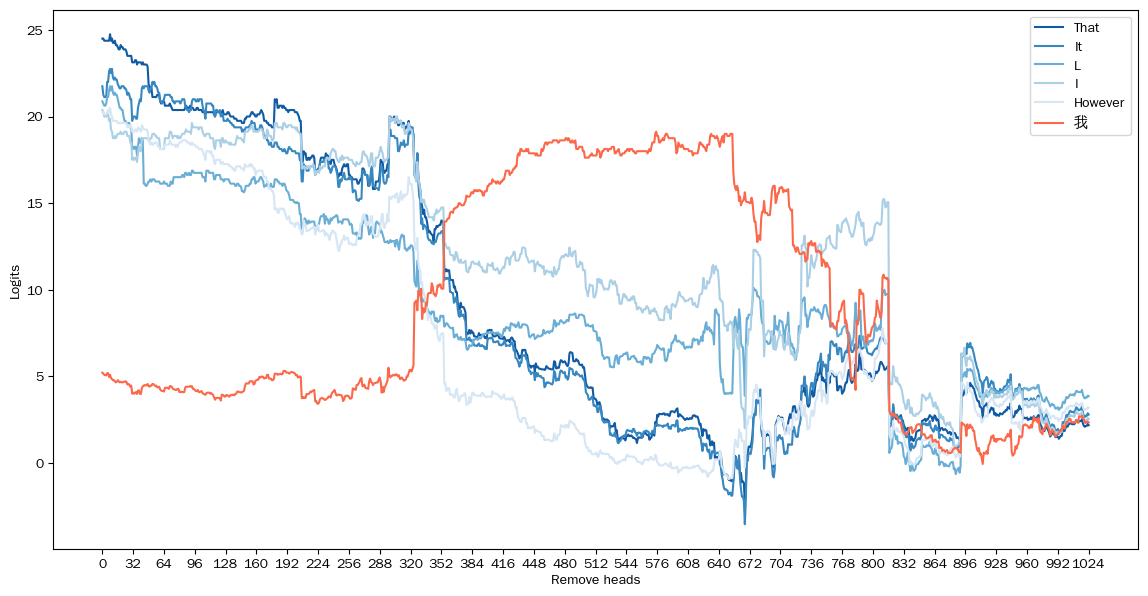

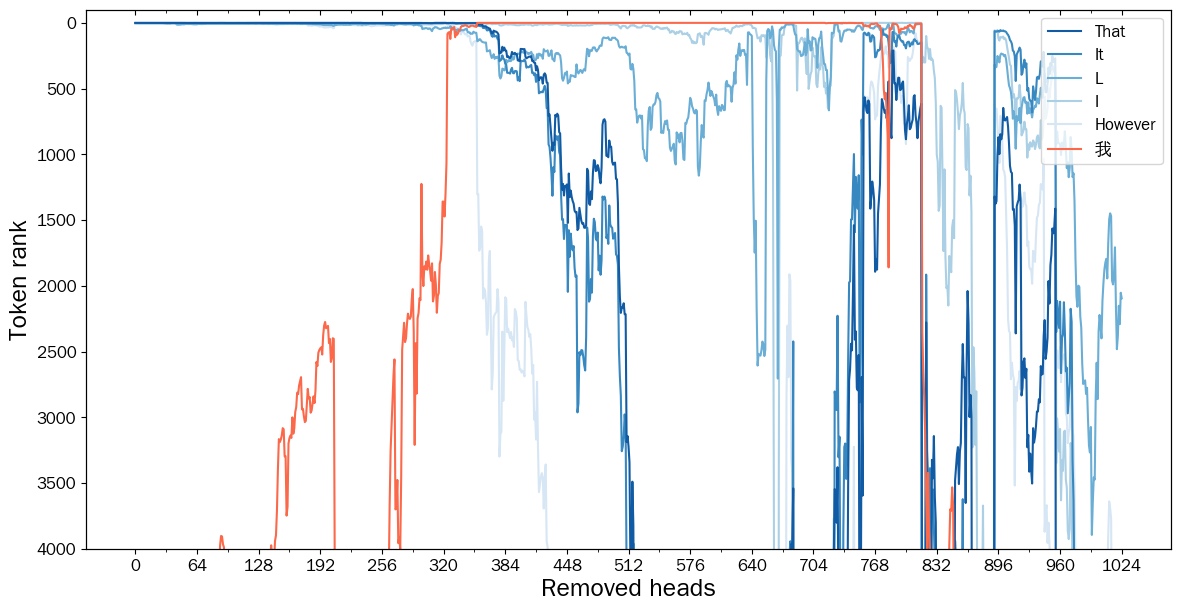

最大rank跃升 6579 于头 986


In [ ]:
plt.rcParams['font.sans-serif'] = ["WenQuanYi Zen Hei"]
import seaborn as sns
colors = sns.color_palette("Blues", 5)[::-1]
red = sns.color_palette("Reds", 1)[-1]
# 绘制logits变化图
fig, ax = plt.subplots(figsize=(14, 7))
for i in range(6):
    if i < 5:
        ax.plot(pred_logits[:, i], label=topk_tokens[i], color=colors[i])
    else:
        ax.plot(pred_logits[:, i], label="我", color=red)
ax.set_xlabel("Remove heads")
ax.set_ylabel("Logits")
ax.set_xticks(range(0, 1025, 32))
plt.legend()
plt.show()
# 绘制rank变化图
fig, ax = plt.subplots(figsize=(14, 7))
# first_top = pred_rank[:320, 5].tolist().index(0)
# ax.axvline(x=first_top, color="gray", linestyle="--", linewidth=0.5)
for i in [4,3,2,1,0,5]:
    if i < 5:
        ax.plot(pred_rank[:, i], label=topk_tokens[i], color=colors[i])
    else:
        ax.plot(pred_rank[:, i], label="我", color=red)
ax.set_xlabel("Removed heads", fontsize=18)
ax.set_ylabel("Token rank", fontsize=18)
ax.set_xticks(np.arange(0, 1025, 64), labels=np.arange(0, 1025, 64), fontsize=12)
ax.set_xticks(np.arange(32, 1025, 64), minor=True)
ax.set_yticks(np.arange(0, 4001, 500), labels=np.arange(0, 4001, 500), fontsize=12)
ax.set_ylim(-100, 4000)
top_ax = ax.twiny()
top_ax.set_xlim(ax.get_xlim())
top_ax.xaxis.tick_top()
top_ax.tick_params(direction="in", which="both")
top_ax.set_xticks(np.arange(0, 1025, 64), labels=[])
top_ax.set_xticks(np.arange(32, 1025, 64), minor=True)
plt.gca().invert_yaxis()
plt.legend([ax.lines[i] for i in [4,3,2,1,0,5]], [topk_tokens[i] for i in range(5)] + ["我"], fontsize=12)
plt.savefig("figs/rank_neg.pdf")
plt.show()
print("最大rank跃升", (pred_rank[1:, -1] - pred_rank[:-1, -1]).max(), "于头", test_order[(pred_rank[1:, -1] - pred_rank[:-1, -1]).argmax() + 1])

注意力在token上的分布

  0%|          | 0/256 [00:00<?, ?it/s]

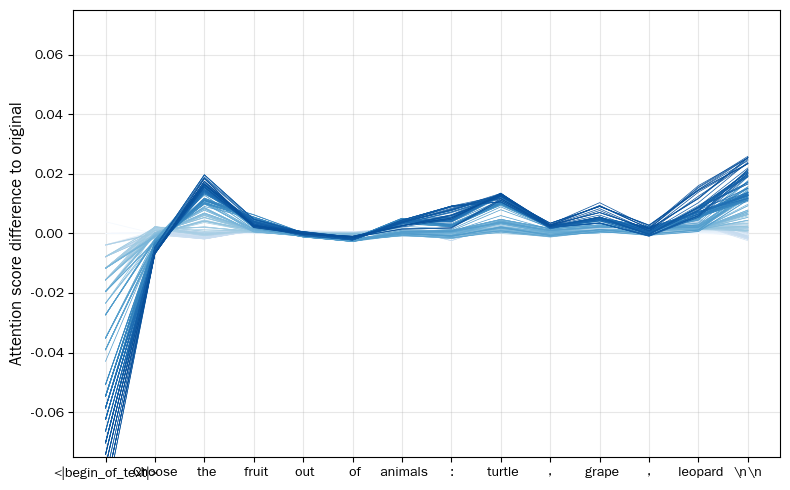

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ["WenQuanYi Zen Hei"]
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
from tqdm.notebook import tqdm
LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "<|begin_of_text|>{src}\n\n"
input_str = "Choose the fruit out of animals: turtle, grape, leopard"
lm_inputs_src = tokenizer([LLAMA_PLM_TEMPLATE.format(src=input_str)], add_special_tokens=False, return_tensors="pt").to(DEVICE)
input_tokens = [tokenizer.decode(t) for t in lm_inputs_src["input_ids"][0]]
input_tokens = [t if t != "\n\n" else r"\n\n" for t in input_tokens]

test_weight = weight_dict["fruit_v_animal_3"].sigmoid().numpy()
test_weight[32::33] = 0
order = test_weight.argsort()[32:]

full_weight = np.ones_like(weight_dict["en_zh"].sigmoid().numpy())
test_tensor = torch.tensor(full_weight).unsqueeze(0).repeat(1, 1).to(model.device)
test_order = test_order[:256]
# test_order = np.random.permutation(order[:200])
token_attentions = []
with torch.no_grad():
    original_output = model(**lm_inputs_src, weight_tensor=test_tensor, output_attentions=True)
    original_attention = torch.stack(original_output.attentions)  # (n_layers, bsz, n_heads, seq_len, seq_len)
    last_token_attn = original_attention[:, -1, :, -1]
    original_token_attention = last_token_attn.mean(dim=(0,1)).float().cpu().numpy()
for head_idx in tqdm(test_order):
    test_tensor[0, head_idx] = 0
    with torch.no_grad():
        original_output = model(**lm_inputs_src, weight_tensor=test_tensor, output_attentions=True)
        original_attention = torch.stack(original_output.attentions)  # (n_layers, bsz, n_heads, seq_len, seq_len)
        last_token_attn = original_attention[:, -1, :, -1]
        last_token_attn[test_tensor.view(32,33)[:, :-1] == 0] = 0
        token_attentions.append((last_token_attn.sum(dim=(0,1)) / (test_tensor.sum() - 32)).float().cpu().numpy())

plt.figure(figsize=(8, 5))
plt.ylim(-0.075, 0.075)
plt.xticks(ticks=range(len(input_tokens)), labels=input_tokens, rotation=0, ha="center")
plt.ylabel("Attention score difference to original", fontsize=12)
colors = sns.color_palette("Blues", 288)
for i, (attention_dist) in enumerate(token_attentions):
    plt.plot(range(len(input_tokens)), attention_dist - original_token_attention, linestyle='-', color=colors[i], linewidth=0.5)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

tensor(818, device='cuda:0')


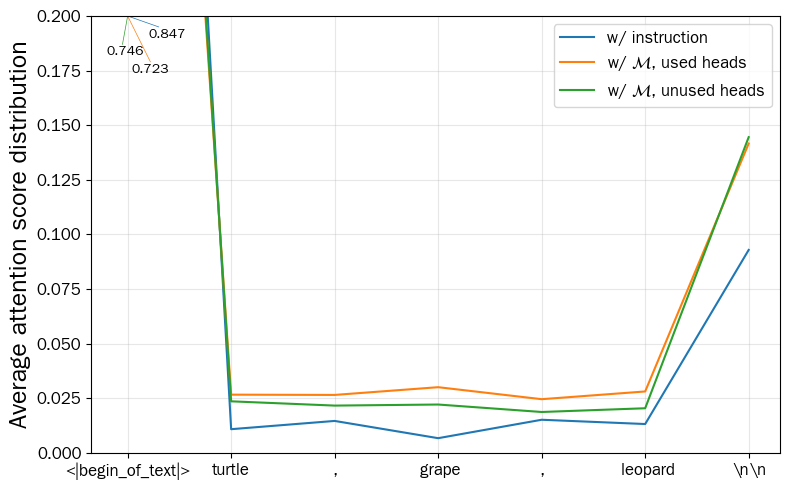

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ["WenQuanYi Zen Hei"]
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
from tqdm.notebook import tqdm
LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "<|begin_of_text|>{src}\n\n"
input_inst_str = "Choose the fruit out of animals: turtle, grape, leopard"
input_str = "turtle, grape, leopard"
lm_inputs_inst_src = tokenizer([LLAMA_PLM_TEMPLATE.format(src=input_inst_str)], add_special_tokens=False, return_tensors="pt").to(DEVICE)
lm_inputs_src = tokenizer([LLAMA_PLM_TEMPLATE.format(src=input_str)], add_special_tokens=False, return_tensors="pt").to(DEVICE)
input_tokens = [tokenizer.decode(t) for t in lm_inputs_src["input_ids"][0]]
input_tokens = [t if t != "\n\n" else r"\n\n" for t in input_tokens]

test_tensor = (weight_dict["fruit_v_animal_3"].sigmoid() >= 0.5).unsqueeze(0).repeat(1, 1).to(model.device)
print(test_tensor.sum())
with torch.no_grad():
    original_output = model(**lm_inputs_inst_src, weight_tensor=None, output_attentions=True)
    original_attention = torch.stack(original_output.attentions)  # (n_layers, bsz, n_heads, seq_len, seq_len)
    last_token_attn = original_attention[:, -1, :, -1]
    original_token_attention = last_token_attn.mean(dim=(0,1)).float().cpu().numpy()
    original_token_attention = original_token_attention[[0, 8,9,10,11,12,13]] / original_token_attention[[0, 8,9,10,11,12,13]].sum()
    original_token_perlayer_attention = last_token_attn.mean(dim=1).float().cpu().numpy()

    weighted_output = model(**lm_inputs_src, weight_tensor=test_tensor, output_attentions=True)
    weighted_attention = torch.stack(weighted_output.attentions)  # (n_layers, bsz, n_heads, seq_len, seq_len)
    last_token_attn = weighted_attention[:, -1, :, -1]
    last_token_attn[test_tensor.view(32,33)[:, :-1] == 0] = 0
    layer_head_num = (test_tensor.view(32,33)[:, :-1] != 0).sum(dim=1)
    weighted_token_attention = (last_token_attn.sum(dim=(0,1)) / (test_tensor.sum() - 32)).float().cpu().numpy()
    weighted_token_perlayer_attention = (last_token_attn.sum(dim=(1)) / layer_head_num.reshape(-1, 1)).float().cpu().numpy()

    weighted_output = model(**lm_inputs_src, weight_tensor=test_tensor, output_attentions=True)
    weighted_attention = torch.stack(weighted_output.attentions)  # (n_layers, bsz, n_heads, seq_len, seq_len)
    last_token_unused_attn = weighted_attention[:, -1, :, -1]
    last_token_unused_attn[test_tensor.view(32,33)[:, :-1] == 1] = 0
    weighted_token_unused_attention = (last_token_unused_attn.sum(dim=(0,1)) / (1056 - test_tensor.sum())).float().cpu().numpy()

plt.figure(figsize=(8, 5))
plt.ylim(0, 0.2)  # Set y-axis range
plt.xticks(ticks=range(len(input_tokens)), labels=input_tokens, rotation=0, ha="center", fontsize=12)
plt.ylabel("Average attention score distribution", fontsize=18)
plt.yticks(fontsize=12)
colors = sns.color_palette(n_colors=3)
# for i in range(32):
#     plt.plot(range(len(input_tokens)), weighted_token_perlayer_attention[i] - original_token_perlayer_attention[i], linestyle='-', color=colors[i])
plt.plot(range(len(input_tokens)), original_token_attention, linestyle='-', label="w/ instruction", c=colors[0])
plt.plot(range(len(input_tokens)), weighted_token_attention, linestyle='-', label=r"w/ $\mathcal{M}$, used heads", c=colors[1])
plt.plot(range(len(input_tokens)), weighted_token_unused_attention, linestyle='-', label=r"w/ $\mathcal{M}$, unused heads", c=colors[2])
plt.plot([0, 0.3], [0.2, 0.195], lw=0.5, c=colors[0])
plt.text(0.2, 0.19, f"{original_token_attention[0]:.3f}")
plt.plot([0, -0.05], [0.2, 0.187], lw=0.5, c=colors[2])
plt.text(-0.2, 0.182, f"{weighted_token_unused_attention[0]:.3f}")
plt.plot([0, 0.22], [0.2, 0.179], lw=0.5, c=colors[1])
plt.text(0.04, 0.174, f"{weighted_token_attention[0]:.3f}")
# plt.plot(range(len(input_tokens)), weighted_token_unused_attention - original_token_attention, linestyle='-')
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("figs/dist.pdf", dpi=150)
plt.show()

按权重由小到大顺序，从部分模型依次恢复注意力头至全模型

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
input_str = "I see a llama sleeping in my backyard. Help!"
lm_inputs_src = tokenizer([LLAMA_TEMPLATE.format(src=input_str)], add_special_tokens=False, return_tensors="pt").to(DEVICE)

test_weight = weight_dict["en_zh"].sigmoid().numpy()
test_weight[32::33] = 0
order = test_weight.argsort()[32:]

test_tensor = (weight_dict["en_zh"].sigmoid() >= 0.5).float().unsqueeze(0).repeat(1, 1).to(model.device)
pred_strs = []
for head_idx in tqdm(order):
    if test_weight[head_idx] > 0.5: break
    test_tensor[0, head_idx] = 1
    with torch.no_grad():
        generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=test_tensor, do_sample=False)
        pred_str = tokenizer.decode(generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
        pred_strs.append(pred_str)
        pd.DataFrame(pred_strs).to_csv("test.csv", encoding="utf-8")

读取mask训练过程的checkpoints，以查看训练过程中权重变化

In [ ]:
import os
import safetensors.torch

step_weight_dict = {}
for root, dir, files in os.walk("./output/xnli/en_zh"):
    for file in files:
        if file.endswith(".safetensors"):
            ckeckpoint = int(os.path.basename(root).split("-")[-1])
            path = os.path.join(root, file)
            step_weight_dict[ckeckpoint] = safetensors.torch.load_file(path)["tensor"]
step_weight_dict = dict(sorted(step_weight_dict.items()))
step_weight_dict

{31: tensor([-3.0063, -3.0006, -2.9760,  ..., -3.0412, -3.0158, -3.0067]),
 62: tensor([-3.0263, -3.0238, -2.9998,  ..., -3.0632, -2.9931, -3.0067]),
 93: tensor([-3.0642, -3.0602, -3.0382,  ..., -3.1013, -2.9540, -3.0067]),
 124: tensor([-3.1199, -3.1073, -3.0897,  ..., -3.1565, -2.9022, -3.0067]),
 155: tensor([-3.1853, -3.1750, -3.1607,  ..., -3.2254, -2.8333, -3.0067]),
 186: tensor([-3.2521, -3.2608, -3.2446,  ..., -3.3129, -2.7451, -3.0067]),
 217: tensor([-3.3444, -3.3585, -3.3456,  ..., -3.4121, -2.6407, -3.0067]),
 248: tensor([-3.4484, -3.4649, -3.4558,  ..., -3.5264, -2.5173, -3.0067]),
 279: tensor([-3.5679, -3.5820, -3.5855,  ..., -3.6468, -2.3783, -3.0067]),
 310: tensor([-3.6964, -3.7130, -3.7281,  ..., -3.7820, -2.2257, -3.0067]),
 341: tensor([-3.8388, -3.8553, -3.8780,  ..., -3.9342, -2.0545, -3.0067]),
 372: tensor([-3.9926, -4.0103, -4.0481,  ..., -4.1013, -1.8629, -3.0067]),
 403: tensor([-4.1865, -4.1631, -4.2334,  ..., -4.2805, -1.6580, -3.0067]),
 434: tensor([-

按训练步数顺序，依次复原注意力头

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
LLAMA_TEMPLATE = "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{src}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
LLAMA_PLM_TEMPLATE = "{src}"
input_str = "I see a sheep sleeping in my backyard."
lm_inputs_src = tokenizer([LLAMA_TEMPLATE.format(src=input_str)], add_special_tokens=False, return_tensors="pt").to(DEVICE)

pred_strs = []
for checkpoint, weight in tqdm(list(step_weight_dict.items())):
    with torch.no_grad():
        test_tensor = (weight.sigmoid() >= 0.5).float().unsqueeze(0).repeat(1, 1).to(model.device)
        generate_ids = model.generate(**lm_inputs_src, max_new_tokens=50, weight_tensor=test_tensor, do_sample=False)
        pred_str = tokenizer.decode(generate_ids[0][lm_inputs_src.input_ids.size(1):], skip_special_tokens=True)
        pred_strs.append(pred_str)
        pd.DataFrame(pred_strs).to_csv("test.csv", encoding="utf-8")

  0%|          | 0/200 [00:00<?, ?it/s]

~/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
~/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [ ]:
for i, (checkpoint, weight) in enumerate(step_weight_dict.items()):
    attn_weight = weight.sigmoid().numpy().reshape(32, 32 + 1)[:, :-1]
    plot_heatmap(attn_weight, idx=i+1)

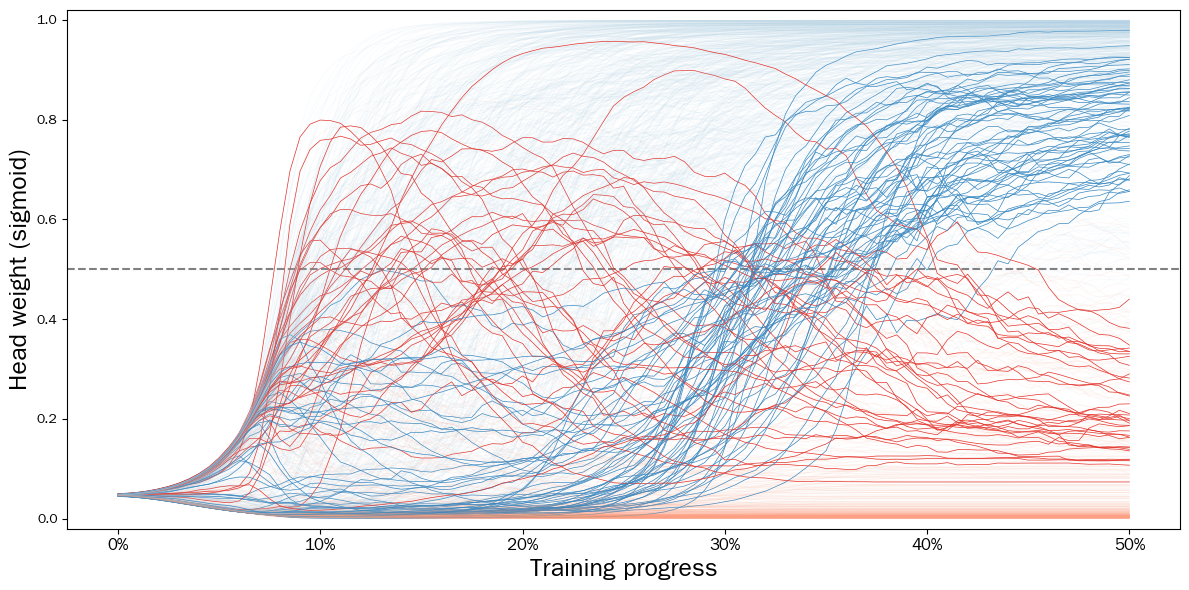

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ["WenQuanYi Zen Hei"]
(b1, b2), (r1, r2) = sns.color_palette("Blues", 2), sns.color_palette("Reds", 2)
step_weight_array = torch.stack([t.view(32, 33)[:, :-1].flatten().sigmoid() for t in step_weight_dict.values()]).numpy()
plt.figure(figsize=(12, 6))
plt.axhline(y=0.5, color="gray", linestyle="--")
for i in range(1024):
    if (step_weight_array[:100, i] < 0.5).all() or (step_weight_array[-1, i] >= 0.5 and (step_weight_array[:60, i] >= 0.5).any()) or (0.3 < step_weight_array[-1, i] <= 0.7):
        c = b1 if step_weight_array[-1, i] >= 0.5 else r1
        plt.plot(range(101), step_weight_array[:101, i], linewidth=0.5, alpha=0.1, color=c)
    else:
        c = b2 if step_weight_array[-1, i] >= 0.5 else r2
        plt.plot(range(101), step_weight_array[:101, i], linewidth=0.5, alpha=1, color=c)

plt.xlabel("Training progress", fontsize=18)
plt.xticks(np.arange(0, 101, 20), labels=["0%", "10%", "20%", "30%", "40%", "50%"], fontsize=12)
plt.ylabel("Head weight (sigmoid)", fontsize=18)
plt.ylim(-0.02, 1.02)
plt.tight_layout()
plt.savefig("figs/changes.pdf", dpi=200)
plt.show()